# Infer EC50 values for the `171207_Eva1` chip

## Import `Python` modules

In [1]:
import os
import sys
import re
import glob

import xml.etree.ElementTree as ET
sys.path.append("/home/jupyter/tacc-work/jupyter_packages/lib/python2.7/site-packages")
from FlowCytometryTools import *

import numpy as np
import pandas
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)

# Initialize directories
resultsdir = "results/171207_Eva1"
resultsdir_parse_metadata = os.path.join(resultsdir, 'parse_metadata')
dirs = [resultsdir, resultsdir_parse_metadata]
for dir_i in dirs:
    if not os.path.isdir(dir_i):
        os.makedirs(dir_i)

## Make the input experimental-summary file

### Specify all inputs

In [2]:
# Specify the location of FASTQ files
fastq_dir = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_7/EVA_chip1_04172018/'
fastq_summary_file = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_7/manifest.csv'

# Specify the locations of directories with FCS files with part of the FACS data
facs_dir = "/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/facs_data/production_data/"
job_ids = ['Job_57343', 'Job_57907', 'Job_57759']
facs_dirs = ','.join([os.path.join(facs_dir, job_id) for job_id in job_ids])
job_ids = ','.join(job_ids)

# Specify the FACS channel name to investigate
facs_channel_name = u'FITC-A'

# Make a list of input XML files with the other part of the FACS data
xml_files = ','.join(glob.glob(
    os.path.join(facs_dir, 'sort_reports', '*/*.xml')
))

# Specify column-specific values to analyze in the metadata files.
library_name = "EVA_Chip1_Jan_2018"
ignore_aq_item_ids = '' # ignore the sequencing data for the (trypsin, 0) file

# Specify the output metadata CSV file
experimental_metadata_output_file = os.path.join(resultsdir_parse_metadata, 'experimental_metadata_from_script.csv')

# Read in input arguments, as if it were a new script
job_ids = job_ids.split(',')
facs_dirs = facs_dirs.split(',')
xml_files = xml_files.split(',')
ignore_aq_item_ids = ignore_aq_item_ids.split(',')

# Read in data on location of deep-sequencing data
fastq_df = pandas.read_csv(fastq_summary_file)

# Remove entires to ignore, as specified above
indices_to_drop = [i for (i, row) in fastq_df.iterrows() if str(row['aq_item_id']) in ignore_aq_item_ids]
fastq_df.drop(indices_to_drop, inplace=True)

# Piece together paths to FASTQ files and tweak some of entries to match
# expected patterns/cases
fastq_df['fastq_id'] = fastq_df.apply(lambda row: os.path.join(
    str(row['aq_item_id']), 'Files/'
), axis=1)
fastq_df['protease'] = fastq_df['protease'].apply(lambda x: x.lower())
fastq_df['strain'] = fastq_df['strain'].apply(lambda x: x.replace(' ', '_'))

# To conform with previous naming schemes, I will relabel the
# naive sample (naive, 0) to be the naive trypsin sample (trypsin, 0)
fastq_df['protease'] = fastq_df['protease'].apply(lambda x: x.replace('naive', 'trypsin'))

# Index by protease name and concentration
fastq_df.set_index(['protease', 'concentration'], inplace=True)

# Downsample to include only samples within library of interest
fastq_df = fastq_df[fastq_df['strain']==library_name]
fastq_df.sort_index(inplace=True)
#fastq_df

Add a column to the above dataframe that indicates the extraction job ID, which indicates whether a sample was processed via the old inefficient extraction protocol or the newer more efficient extraction protocol.

In [3]:
# Add extraction job ids to the dataframe using the aq ids to
# map these values
aq_item_id_to_extract_job_id = {
125936:58155,
125937:58155,
125938:58155,
125939:58155,
125940:58155,
125941:58155,
125942:58155,
125943:58155,
125944:58155,
125945:58155,
125946:58241,
125947:58241,
125948:58241,
125949:60287,
125950:60287,
125951:60287,
125952:60287,
125953:60287,
125954:60287,
125955:60287,
125956:60287,
125957:60287,
125958:60287
}
fastq_df['extraction_job_id'] = fastq_df['aq_item_id'].apply(lambda x: aq_item_id_to_extract_job_id[x])

# For each sample (defined by protease name and concentration), find the
# experiment with highest `extraction_job_id`
rows_to_keep = []
experiments = list(set(fastq_df.index.values))
for experiment in experiments:
    (protease, concentration) = experiment
    extraction_job_ids = sorted(list(fastq_df.loc[experiment]['extraction_job_id']))
    highest_extraction_job_id = max(extraction_job_ids)
    rows_to_keep.append((protease, concentration, highest_extraction_job_id))

fastq_df.reset_index(inplace=True, drop=False)
fastq_df.set_index(['protease', 'concentration', 'extraction_job_id'], inplace=True)
fastq_df = fastq_df.loc[rows_to_keep]
fastq_df.reset_index(inplace=True, drop=False)
fastq_df.set_index(['protease', 'concentration'], inplace=True)
fastq_df.sort_index(inplace=True)
fastq_df

extraction_job_id  aq_item_id  plan_id  \
protease     concentration                                           
chymotrypsin 9.5                        60287      125950  10062.0   
             28.0                       60287      125951  10062.0   
             83.0                       58241      125947  10062.0   
             250.0                      60287      125955  10062.0   
             750.0                      58241      125948  10062.0   
             2250.0                     60287      125956  10062.0   
trypsin      0.0                        60287      125952      NaN   
             9.5                        58241      125946  10062.0   
             28.0                       60287      125949  10062.0   
             83.0                       60287      125953  10062.0   
             250.0                      60287      125958  10062.0   
             750.0                      60287      125954  10062.0   
             2250.0                     60287      125957  10062.0   

                                        strain       fastq_id  
protease     concentration                                     
chymotrypsin 9.5            EVA_Chip1_Jan_2018  125950/Files/  
             28.0           EVA_Chip1_Jan_2018  125951/Files/  
             83.0           EVA_Chip1_Jan_2018  125947/Files/  
             250.0          EVA_Chip1_Jan_2018  125955/Files/  
             750.0          EVA_Chip1_Jan_2018  125948/Files/  
             2250.0         EVA_Chip1_Jan_2018  125956/Files/  
trypsin      0.0            EVA_Chip1_Jan_2018  125952/Files/  
             9.5            EVA_Chip1_Jan_2018  125946/Files/  
             28.0           EVA_Chip1_Jan_2018  125949/Files/  
             83.0           EVA_Chip1_Jan_2018  125953/Files/  
             250.0          EVA_Chip1_Jan_2018  125958/Files/  
             750.0          EVA_Chip1_Jan_2018  125954/Files/  
             2250.0         EVA_Chip1_Jan_2018  125957/Files/

### For each sample in the experiment, quantify the total number of events and the number of events that passed the sorting threshold

In [4]:
def s_log(sample, channel_names):
    new_sample = sample.copy()
    new_data = new_sample.data

    for channel_name in channel_names:
        new_data[channel_name] = np.log10(new_data[channel_name])
        
    new_data.replace(to_replace = -np.inf, value = -1, inplace = True)
    new_data = new_data.dropna()
    new_sample.data = new_data
    
    return new_sample

In [5]:
# Read in data from the `manifest.txt` files
manifest_df = pandas.DataFrame()
for (job_id, facs_dir) in zip(job_ids, facs_dirs):
    df = pandas.read_csv(os.path.join(facs_dir, 'manifest.txt'))
    df['job_id'] = job_id
    df['directory'] = facs_dir
    df['specimen'] = df['filename'].apply(lambda x : x[:12])
    df['tube'] = df['filename'].apply(lambda x : x[13:21])
    df['strain'] = df['strain'].apply(lambda x: x.replace(' ', '_'))
    manifest_df = pandas.concat([manifest_df, df])
manifest_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)

In [6]:
# Quantify the total number of events and events passing the gate
fitc_data_dict = {}
total_number_of_recorded_events = []
number_of_events_passing_fitc_gate = []
for (i, row) in manifest_df.iterrows():
    
    # Read in the data for the appropriate channel and transform it to a log10 scale
    fcs_file = os.path.join(row['directory'], row['filename'])
    sample = FCMeasurement(ID='Test Sample', datafile=fcs_file)
    #print("Analyzing the channel: {0}".format(channel_name))
    sample = s_log(sample, [facs_channel_name])
    df = sample.data
    
    # Count the number of total events and events passing the gate
    total_number_of_recorded_events.append(len(df.index.values))
    number_of_events_passing_fitc_gate.append(
        sum(df[facs_channel_name] > 3.0)
    )

# Append the FACS data to the manifest dataframe
manifest_df['total_number_of_recorded_events'] = total_number_of_recorded_events
manifest_df['number_of_events_passing_fitc_gate'] = number_of_events_passing_fitc_gate
manifest_df['fraction_collected'] = \
    manifest_df['number_of_events_passing_fitc_gate'] / manifest_df['total_number_of_recorded_events']
columns_to_show = [
    'strain', 'protease', 'concentration', 'total_number_of_recorded_events',
    'number_of_events_passing_fitc_gate', 'fraction_collected'
]
manifest_df = manifest_df[
    manifest_df['strain'] == library_name
]
manifest_df[columns_to_show]

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


strain      protease  \
job_id    specimen     tube                                         
Job_57343 Specimen_001 Tube_006  EVA_Chip1_Jan_2018       trypsin   
                       Tube_007  EVA_Chip1_Jan_2018       trypsin   
                       Tube_008  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip1_Jan_2018  chymotrypsin   
Job_57907 Specimen_001 Tube_002  EVA_Chip1_Jan_2018       trypsin   
                       Tube_003  EVA_Chip1_Jan_2018       trypsin   
                       Tube_004  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_005  EVA_Chip1_Jan_2018  chymotrypsin   
Job_57759 Specimen_001 Tube_006  EVA_Chip1_Jan_2018       trypsin   
                       Tube_007  EVA_Chip1_Jan_2018       trypsin   
                       Tube_008  EVA_Chip1_Jan_2018  chymotrypsin   
                       Tube_009  EVA_Chip1_Jan_2018  chymotrypsin   

                                 concentration  \
job_id    specimen     tube                      
Job_57343 Specimen_001 Tube_006            9.5   
                       Tube_007           28.0   
                       Tube_008            9.5   
                       Tube_009           28.0   
Job_57907 Specimen_001 Tube_002          750.0   
                       Tube_003         2250.0   
                       Tube_004          750.0   
                       Tube_005         2250.0   
Job_57759 Specimen_001 Tube_006           83.0   
                       Tube_007          250.0   
                       Tube_008           83.0   
                       Tube_009          250.0   

                                 total_number_of_recorded_events  \
job_id    specimen     tube                                        
Job_57343 Specimen_001 Tube_006                            99997   
                       Tube_007                            99995   
                       Tube_008                           100000   
                       Tube_009                            99994   
Job_57907 Specimen_001 Tube_002                            99997   
                       Tube_003                            99998   
                       Tube_004                            99998   
                       Tube_005                            99996   
Job_57759 Specimen_001 Tube_006                           100000   
                       Tube_007                            99997   
                       Tube_008                           100000   
                       Tube_009                            99998   

                                 number_of_events_passing_fitc_gate  \
job_id    specimen     tube                                           
Job_57343 Specimen_001 Tube_006                               10055   
                       Tube_007                               10185   
                       Tube_008                               17636   
                       Tube_009                               15549   
Job_57907 Specimen_001 Tube_002                                6611   
                       Tube_003                                2397   
                       Tube_004                                9189   
                       Tube_005                                2181   
Job_57759 Specimen_001 Tube_006                               27763   
                       Tube_007                               16076   
                       Tube_008                               33265   
                       Tube_009                               20572   

                                 fraction_collected  
job_id    specimen     tube                          
Job_57343 Specimen_001 Tube_006            0.100553  
                       Tube_007            0.101855  
                       Tube_008            0.176360  
                       Tube_009            0.155499  
Job_57907 Specimen_001 Tube_002            0.066112  
                       Tube_003            0.023970

Read in data from the XML files on the total number of cells collected. I will do this for all XML files the BIOFAB has uploaded, even ones that aren't relevant to this experiment. Then, I will identify the relevant ones using the `job_id`, `specimen`, and `tube` columns.

In [7]:
# Compile data in each XML file
xml_data_dict = {
    key : []
    for key in ['job_id', 'specimen', 'tube', 'cells_collected', 'intended_number_of_cells_collected'] #
}
cells_collected_pattern = re.compile(r'\w+ : (?P<cells_collected>\d+) / (?P<intended_number_of_cells_collected>\d+)')
for filename in xml_files:
    tree = ET.parse(filename)
    root = tree.getroot()

    # Get experiment metadata
    xml_data_dict['job_id'].append( root.findall(".//*[@name='Experiment']")[0].get('value') )
    xml_data_dict['specimen'].append( root.findall(".//*[@name='Specimen']")[0].get('value') )
    xml_data_dict['tube'].append( root.findall(".//*[@name='Tube']")[0].get('value') )
    xml_data_dict['xmlfile'] = filename
    
    # Get experiment counts
    cells_collected_data = root[4].findall(".//*[@col='1']")[0].text
    match = re.match(cells_collected_pattern, cells_collected_data)
    if match:
        xml_data_dict['cells_collected'].append(
            int(match.group('cells_collected'))
        )
        xml_data_dict['intended_number_of_cells_collected'].append(
            int(match.group('intended_number_of_cells_collected'))
        )
    else:
        xml_data_dict['cells_collected'].append(None)
        xml_data_dict['intended_number_of_cells_collected'].append(None)
          
# Convert data to a dataframe
xml_data_df = pandas.DataFrame.from_dict(xml_data_dict)
xml_data_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)
#xml_data_df

Merge the FACS data from the two input sources

In [8]:
facs_df = manifest_df.merge(xml_data_df, left_index=True, right_index=True, how='left')
facs_df = facs_df[
    facs_df['strain'] == library_name
]
facs_df.set_index(['protease', 'concentration'], inplace=True, drop=False)
columns_to_show = ['cells_collected', 'fraction_collected']
facs_df[columns_to_show].sort_index()

cells_collected  fraction_collected
protease     concentration                                     
chymotrypsin 9.5                  2136000.0            0.176360
             28.0                 1830905.0            0.155499
             83.0                 2150790.0            0.332650
             250.0                1058966.0            0.205724
             750.0                 726789.0            0.091892
             2250.0                129911.0            0.021811
             2250.0                 34670.0            0.021811
trypsin      9.5                  1058671.0            0.100553
             28.0                 1236000.0            0.101855
             83.0                 2402586.0            0.277630
             250.0                1739743.0            0.160765
             750.0                 676647.0            0.066112
             2250.0                300000.0            0.023970

Merge the FACS and deep-sequencing data

In [9]:
df = fastq_df.merge(facs_df, left_index=True, right_index=True, how="outer")
columns_to_write = ['fastq_id', 'cells_collected', 'fraction_collected']
df = df[columns_to_write]
df.reset_index(inplace=True)
df

,protease,concentration,fastq_id,cells_collected,fraction_collected
0,chymotrypsin,9.5,125950/Files/,2136000.0,0.176360
1,chymotrypsin,28.0,125951/Files/,1830905.0,0.155499
2,chymotrypsin,83.0,125947/Files/,2150790.0,0.332650
3,chymotrypsin,250.0,125955/Files/,1058966.0,0.205724
4,chymotrypsin,750.0,125948/Files/,726789.0,0.091892
5,chymotrypsin,2250.0,125956/Files/,129911.0,0.021811
6,chymotrypsin,2250.0,125956/Files/,34670.0,0.021811
7,trypsin,0.0,125952/Files/,NaN,NaN
8,trypsin,9.5,125946/Files/,1058671.0,0.100553
9,trypsin,28.0,125949/Files/,1236000.0,0.101855


There are two entries for (chymotrypsin, 2250.0) one with a large number of counts, one with a small number. I will remove the row with the smaller number.

In [10]:
df.drop([6], inplace=True)

Add a row for a naive sample for chymotrypsin, using the same deep-sequencing data as for trypsin 

In [11]:
df_with_extra_row = pandas.DataFrame.from_dict(
    {
        'protease' : ['chymotrypsin'],
        'concentration' : [0],
        'fastq_id' : [df.iloc[6]['fastq_id']],
        'cells_collected' : [df.iloc[6]['cells_collected']],
        'fraction_collected' : [df.iloc[6]['fraction_collected']]
    }
)
df_with_extra_row
df = pandas.concat([df, df_with_extra_row])

Show concatenated dataframe, sorted by protease and protease concentration.

In [12]:
df.sort_values(by=['protease', 'concentration'], inplace=True)
df

,cells_collected,concentration,fastq_id,fraction_collected,protease
0,NaN,0.0,125952/Files/,NaN,chymotrypsin
0,2136000.0,9.5,125950/Files/,0.176360,chymotrypsin
1,1830905.0,28.0,125951/Files/,0.155499,chymotrypsin
2,2150790.0,83.0,125947/Files/,0.332650,chymotrypsin
3,1058966.0,250.0,125955/Files/,0.205724,chymotrypsin
4,726789.0,750.0,125948/Files/,0.091892,chymotrypsin
5,129911.0,2250.0,125956/Files/,0.021811,chymotrypsin
7,NaN,0.0,125952/Files/,NaN,trypsin
8,1058671.0,9.5,125946/Files/,0.100553,trypsin
9,1236000.0,28.0,125949/Files/,0.101855,trypsin


Manually add missing columns

In [13]:
# Add columns
df['experiment_id'] = library_name
df['selection_strength'] = 2 * [i for i in range(0,7)]
df['conc_factor'] = 2 * ['', '3', '3', '3', '3', '3', '3']
df['parent'] = 2 * ['', '0', '0', '2', '2', '4', '4']
df['parent_expression'] = ['' for i in range(len(df.index.values))]

Rename columns and show the final dataframe.

In [14]:
# Rename columns
df.rename(
    {'protease':'protease_type'},
    inplace=True,
    axis='columns'
)
column_order = [
    'experiment_id', 'protease_type', 'concentration', 'selection_strength', 'parent', 'conc_factor', 'fastq_id',
    'parent_expression', 'fraction_collected', 'cells_collected'
]
df[column_order]

,experiment_id,protease_type,concentration,selection_strength,parent,conc_factor,fastq_id,parent_expression,fraction_collected,cells_collected
0,EVA_Chip1_Jan_2018,chymotrypsin,0.0,0,,,125952/Files/,,NaN,NaN
0,EVA_Chip1_Jan_2018,chymotrypsin,9.5,1,0,3,125950/Files/,,0.176360,2136000.0
1,EVA_Chip1_Jan_2018,chymotrypsin,28.0,2,0,3,125951/Files/,,0.155499,1830905.0
2,EVA_Chip1_Jan_2018,chymotrypsin,83.0,3,2,3,125947/Files/,,0.332650,2150790.0
3,EVA_Chip1_Jan_2018,chymotrypsin,250.0,4,2,3,125955/Files/,,0.205724,1058966.0
4,EVA_Chip1_Jan_2018,chymotrypsin,750.0,5,4,3,125948/Files/,,0.091892,726789.0
5,EVA_Chip1_Jan_2018,chymotrypsin,2250.0,6,4,3,125956/Files/,,0.021811,129911.0
7,EVA_Chip1_Jan_2018,trypsin,0.0,0,,,125952/Files/,,NaN,NaN
8,EVA_Chip1_Jan_2018,trypsin,9.5,1,0,3,125946/Files/,,0.100553,1058671.0
9,EVA_Chip1_Jan_2018,trypsin,28.0,2,0,3,125949/Files/,,0.101855,1236000.0


Write the above dataframe to an output file

In [15]:
print("Writing metadata to the experimental summary file: {0}".format(experimental_metadata_output_file))
df[column_order].to_csv(experimental_metadata_output_file, index=False)

Writing metadata to the experimental summary file: results/171207_Eva1/parse_metadata/experimental_metadata_from_script.csv


**Note, I made an additional manual tweak to the expreimental-summary file created in the above cell**. For some reason, only one of the four pairs of FASTQ files for the chymotrypsin sample for selection index 2 have an appreciable number of reads. So, I will alter the `fastq_id` entry for the sample to specifically correspond to the pair of FASTQ files that actually have a large number of reads. To do so, I will change it from `125951/Files/` to `125951/Files/125951-Chymotrypsin-28_S16_L001`.

## Compute EC50 values from the input deep-sequencing and FACS data

In [ ]:
# Define input variables
data_dir = 'data/171207_Eva1/'
designed_sequences_file = os.path.join(data_dir, 'designed_sequences_eva1.csv')
experimental_summary_file = os.path.join(experimental_metadata_output_file)
fastq_dir = fastq_dir
pear_path = '/home/05402/haddox/software/pear/bin/pear'
output_dir = resultsdir

In [ ]:
# Write the command to carry everything out
cmd = ' '.join([
    'python',
    'scripts/compute_ec50_values_from_deep_sequencing_data.py',
    '--designed_sequences_file {0}'.format(designed_sequences_file),
    '--experimental_summary_file {0}'.format(experimental_summary_file),
    '--fastq_dir {0}'.format(fastq_dir),
    '--pear_path {0}'.format(pear_path),
    '--output_dir {0}'.format(output_dir)
])

#! {cmd}
print(cmd)

Read in the stability scores for each protease and make a single dataframe with data from each, with suffixes of `_t` or `_c` indicating that the data is derived from trypsin or chymotrypsin, respectively.

In [2]:
# Read in data for each protease, making the `name` column the index
# in each case
trypsin_df = pandas.read_csv(
    os.path.join(resultsdir, 'stability_scores/trypsin_stability_scores.txt'), sep='\t'
)
chymotrypsin_df = pandas.read_csv(
    os.path.join(resultsdir, 'stability_scores/chymotrypsin_stability_scores.txt'), sep='\t'
)
trypsin_df.set_index('name', inplace=True)
chymotrypsin_df.set_index('name', inplace=True)

# Merge the dataframes, using `_t` and `_c` as suffixes to indicate
# which data is from trypsin and chymotrypsin, respectively
stability_scores_df = trypsin_df.merge(
    chymotrypsin_df,
    left_index=True,
    right_index=True,
    how='outer',
    suffixes=['_t', '_c']
)
stability_scores_df['stabilityscore'] = stability_scores_df.apply(
    lambda row: min(row['stabilityscore_t'], row['stabilityscore_c']), axis=1
)
stability_scores_outfile = os.path.join(resultsdir, 'stability_scores/stability_scores.txt')
print("Writing merged stability scores to the file: {0}".format(stability_scores_outfile))
stability_scores_df.to_csv(stability_scores_outfile, sep='\t')

Writing merged stability scores to the file: results/171207_Eva1/stability_scores/stability_scores.txt


Look at the correlation between the stability scores for trypsin and chymotrypsin.

0.452809211143


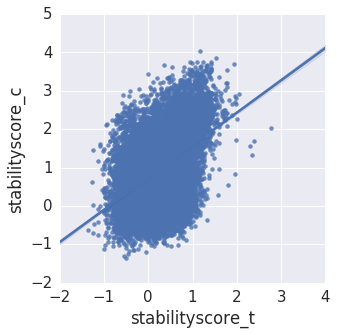

In [3]:
print(stability_scores_df['stabilityscore_t'].corr(stability_scores_df['stabilityscore_c']))
sns.lmplot(x='stabilityscore_t', y='stabilityscore_c', data=stability_scores_df)

Look at the distribution of stability scores for trypsin and chymotrypsin.

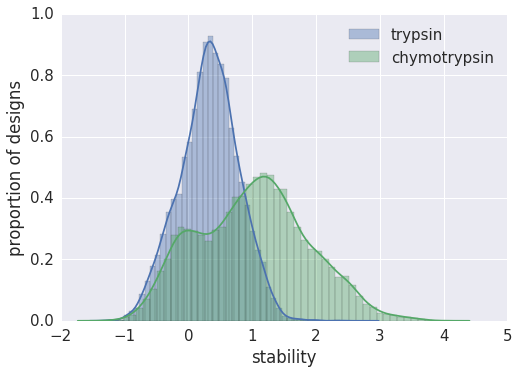

In [4]:
sns.distplot(stability_scores_df['stabilityscore_t'], label='trypsin')
sns.distplot(stability_scores_df['stabilityscore_c'], label='chymotrypsin')
plt.ylabel('proportion of designs')
plt.xlabel('stability')
plt.legend()
plt.show()

## To do:

* Quantify sequencing depth
* Look at the distribution of counts over time

Quantify the number of assembled reads per sample

In [ ]:
def ParsePAREOutfile(outfile):
    """
    This function parses the output data generated by PARE when assemblying paired-end reads
    
    Args:
        `outfile`: the path to a file with the output data generated by PARE
        
    Returns:
        A tupple with the following three variables in the order they appear in the below list:
            `n_assembled_reads` : the total number of assembled reads
            `n_discarded_reads` : the total number of discarded reads
            `n_non_assembled_reads` : the total number of non_assembled_reads
    """
    
    # Pattern used to extract data
    n_reads_pattern = re.compile(r'\: (?P<n_reads>[\d,]+) /')
    
    # Use regular expressions to extract the relevant info from the file
    n_assembled_reads = n_discarded_reads = n_non_assembled_reads = n_total_reads = None
    with open(outfile) as f:
        #print(f.readlines())
        for line in f:
            if 'Assembled reads .' in line:
                if n_assembled_reads:
                    raise ValueError("Already found data for `n_assembled_reads`")
                n_assembled_match = re.search(n_reads_pattern, line)
                n_assembled_reads = int(n_assembled_match.group('n_reads').replace(',', ''))
                
            elif 'Discarded reads .' in line:
                if n_discarded_reads:
                    raise ValueError("Already found data for `n_discarded_reads`")
                n_discarded_match = re.search(n_reads_pattern, line)
                n_discarded_reads = int(n_discarded_match.group('n_reads').replace(',', ''))
                
            elif 'Not assembled reads .' in line:
                if n_non_assembled_reads:
                    raise ValueError("Already found data for `n_non_assembled_reads`")
                n_non_assembled_match = re.search(n_reads_pattern, line)
                n_non_assembled_reads = int(n_non_assembled_match.group('n_reads').replace(',', ''))
    
    return (n_assembled_reads, n_discarded_reads, n_non_assembled_reads)


In [ ]:
# Find log files from PARE
pare_log_dir = os.path.join(resultsdir, 'paired_FASTQ_files')

selection_indices = list(range(0,7))
experiment_names = ['trypsin_{0}'.format(i) for i in selection_indices] + \
    ['chymotrypsin_{0}'.format(i) for i in selection_indices]
log_files = glob.glob(os.path.join(pare_log_dir, '*.log'))
log_files_dict = {
    experiment_name : []
    for experiment_name in experiment_names
}
# For each log file, look for an experimental name that matches the beginning
# of the base name of the log file
for log_file_name in log_files:
    matching_experiments = []
    for experiment_name in log_files_dict:
        log_file_basename = os.path.basename(log_file_name)
        if log_file_basename.find('{0}-'.format(experiment_name)) == 0:
            log_files_dict[experiment_name].append(log_file_name)
            matching_experiments.append(experiment_name)
    if len(matching_experiments) == 0:
        raise ValueError("Could not find a matching experiment for the log file: {0}".format(log_file_name))
    if len(matching_experiments) > 1:
        print(matching_experiments)
        raise ValueError("Found multiple matching experiments for the log file: {0}".format(log_file_name))
    assert len(matching_experiments) == 1

In [ ]:
# Read in depth and quality scores from the output of the `PEAR` program and store in a pandas dataframe
assembly_d = {
    key : []
    for key in ['experiment_name', 'n_assembled_reads', 'n_discarded_reads', 'n_non_assembled_reads']
}
for experiment_name in log_files_dict:
    assembly_d['experiment_name'].append(experiment_name)
    n_assembled_reads = n_discarded_reads = n_non_assembled_reads = 0
    for log_file_name in log_files_dict[experiment_name]:
        (n_assembled_reads_i, n_discarded_reads_i, n_non_assembled_reads_i) = \
            ParsePAREOutfile(log_file_name)
        n_assembled_reads += n_assembled_reads_i
        n_discarded_reads += n_discarded_reads_i
        n_non_assembled_reads += n_non_assembled_reads_i
    assembly_d['n_assembled_reads'].append(n_assembled_reads)
    assembly_d['n_discarded_reads'].append(n_discarded_reads)
    assembly_d['n_non_assembled_reads'].append(n_non_assembled_reads)

assembly_df = pandas.DataFrame.from_dict(assembly_d)

# Plot the data for each replicate as stacked bar charts
fig = plt.figure(figsize=(10,7))

# Get data for each bar
assembly_df.set_index('experiment_name', inplace=True)
labels = sorted(assembly_df.index.values)
first_bar = assembly_df.loc[labels]['n_assembled_reads']
second_bar = assembly_df.loc[labels]['n_non_assembled_reads']
third_bar = assembly_df.loc[labels]['n_discarded_reads']
assert(len(first_bar) == len(second_bar))

# Make plot
plot_indices = np.arange(len(first_bar))
width = 0.35
plt.barh(plot_indices, first_bar, label='assembled', align='center')
plt.barh(plot_indices, second_bar, left=first_bar, label='non-assembled', color='red', align='center')
plt.barh(plot_indices, third_bar, left=second_bar, label='discarded', color='purple', align='center')
plt.yticks(plot_indices, labels)
plt.xlabel('Number of reads')
plt.legend()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
def adjust_ylim(l):
    mn, mx = l
    mn += 1.5
    mx -= .5
    return (mn, mx)
plt.ylim(adjust_ylim(plt.ylim()))
plt.yticks()

Look at the distribution of stability scores

In [ ]:
trypsin_df = pandas.read_csv('results/Inna_April_2016/stability_scores/trypsin_stability_scores.txt', sep='\t')
chymotrypsin_df = pandas.read_csv('results/Inna_April_2016/stability_scores/chymotrypsin_stability_scores.txt', sep='\t')
sns.distplot(trypsin_df['stabilityscore'])
sns.distplot(chymotrypsin_df['stabilityscore'])
plt.show()

In [ ]:
trypsin_df

## Old code

Old code for making the experimental summary file through a separate script

In [ ]:
# Specify the location of FASTQ files
fastq_dir = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/ngs_data/run_4'

# Specify the locations of directories with FCS files with part of the FACS data 
facs_dir = "/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/facs_data/production_data/"
job_ids = ['Job_56649', 'Job_56497', 'Job_56243']
facs_dirs = ','.join([os.path.join(facs_dir, job_id) for job_id in job_ids])
job_ids = ','.join(job_ids)

# Specify the FACS channel name to investigate
facs_channel_name = u'FITC-A'

# Make a list of input XML files with the other part of the FACS data
xml_files = ','.join(glob.glob(
    os.path.join(facs_dir, 'sort_reports', '*/*.xml')
))

# Specify column-specific values to analyze in the metadata files.
library_name = "Inna_April_2016"
ignore_aq_item_ids = '118852'

# Specify the output metadata CSV file
output_file = os.path.join(resultsdir_parse_metadata, 'experimental_metadata_from_script.csv')

# Carry out the command
cmd = ' '.join([
    'python',
    'scripts/parse_metadata.py',
    '--fastq_dir {0}'.format(fastq_dir),
    "--job_ids {0}".format(job_ids),
    "--facs_dirs {0}".format(facs_dirs),
    "--facs_channel_name {0}".format(facs_channel_name),
    "--xml_files {0}".format(xml_files),
    "--library_name {0}".format(library_name),
    "--ignore_aq_item_ids".format(ignore_aq_item_ids),
    "--output_file {0}".format(output_file)
])

! {cmd}